# Introduction
On this project I will try to predict if an ad will be clicked or not.

As starting point, I will use the following features to predict my target:   
* CTR(# of clicks/# of views) of each ad
* timestamp
* platform (desktop, mobile, tablet)
* total clicks per ad
* country

Gradient Boosted Tree performed better on my data.


As next steps I will incorporate new features and increase tha dataset volume.

In [4]:
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [13]:
df = sqlContext.read.format('com.databricks.spark.csv')\
.options(header='true', inferschema='true').load('hdfs:///data/baseline2/*.csv')

In [14]:
drop_list = ['document_id']

df = df.select([column for column in df.columns 
                if column not in drop_list])

# Exploring the data

In [7]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
ad_id,450859,450859,450859,450859,450859
timestamp,76924970,76924970,76924970,76924970,76924970
platform,1,1,1,1,1
clicked,1,1,0,0,0
views_count,885436,885436,885436,885436,885436
total_clicks,47437,47437,47437,47437,47437
CTR,18.6655,18.6655,18.6655,18.6655,18.6655
country,US,US,US,US,US


In [8]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ad_id,4621763,231213.38195338013,175759.4462916522,12610,541423
timestamp,4621763,4.8555715188527405E7,2.1007096120150592E7,1495,86386040
platform,4621763,1.5763971454183177,0.5896427692534428,1,3
clicked,4621763,0.15751110561056464,0.36428201428589513,0,1
views_count,4621763,785372.4295233226,622210.1557431365,7,1558430
total_clicks,4621763,130511.44138459717,139850.1450324197,5,325220


In [9]:
df.printSchema()

root
 |-- ad_id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- platform: integer (nullable = true)
 |-- clicked: integer (nullable = true)
 |-- views_count: integer (nullable = true)
 |-- total_clicks: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- country: string (nullable = true)



In [ ]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# preparing the data for ML

In [15]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['ad_id', 'platform', 'country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'clicked', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['CTR', 'total_clicks', 'views_count', 'timestamp']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [16]:
from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- ad_id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- platform: integer (nullable = true)
 |-- clicked: integer (nullable = true)
 |-- views_count: integer (nullable = true)
 |-- total_clicks: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- country: string (nullable = true)



In [17]:
# split data
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3234673
Test Dataset Count: 1387090


# LR Model

In [18]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

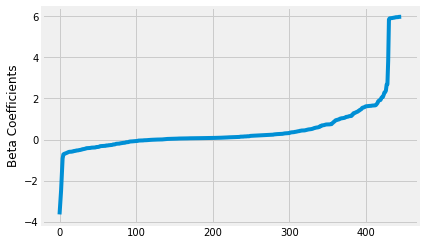

In [19]:
# coefficients plot
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

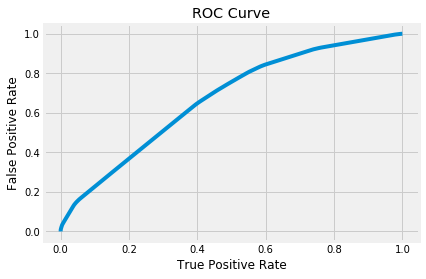

Training set areaUnderROC: 0.670290891331


In [20]:
# Summarize the model over the training set
# we can also obtain the receiver-operating characteristic and areaUnderROC.
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

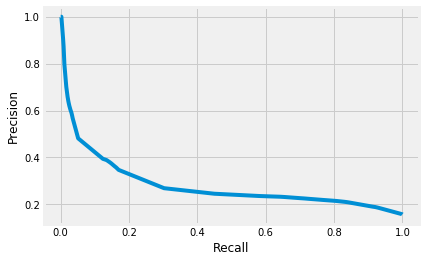

In [21]:
# precison and recall 
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [36]:
#make predictions on the test set
predictions = lrModel.transform(test)
(predictions.select('ad_id',
 'timestamp',
 'platform',
 'views_count',
 'total_clicks',
 'CTR',
 'country', 'label', 'rawPrediction','prediction', 'probability').show(3))

+------+---------+--------+-----------+------------+-----------------+-------+-----+--------------------+----------+--------------------+
| ad_id|timestamp|platform|views_count|total_clicks|              CTR|country|label|       rawPrediction|prediction|         probability|
+------+---------+--------+-----------+------------+-----------------+-------+-----+--------------------+----------+--------------------+
|450859|  3893377|       1|     885436|       47437|18.66551426101988|     US|  0.0|[2.85532928068452...|       0.0|[0.94559350720337...|
|450859|  3893377|       1|     885436|       47437|18.66551426101988|     US|  0.0|[2.85532928068452...|       0.0|[0.94559350720337...|
|450859|  3893377|       1|     885436|       47437|18.66551426101988|     US|  0.0|[2.85532928068452...|       0.0|[0.94559350720337...|
+------+---------+--------+-----------+------------+-----------------+-------+-----+--------------------+----------+--------------------+
only showing top 3 rows



In [25]:
# evaluate Logistic Regression Moddel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

('Test Area Under ROC', 0.6705879224496684)


# Decision Tree Classifier

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

In [28]:
# evaluate Decision Tree Moddel
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.611535261741


Use ensemble methods (Random Forest, Gradient Boosted Tree) to improve the model

# Random Forest Classifier

In [30]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [32]:
# evaluate Random Forest Classifier
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.666330863493


# Gradient Boosted Tree Classifier

In [33]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

In [34]:
# evaluate Gradient Boosted Tree Classifier
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.671387400671
